In [1]:
import torch
from torch import argmax, argsort, relu
from torchvision.models import alexnet
from torchsummary import summary
from utils import classify
import cv2
import numpy as np
from matplotlib import pyplot as plt
from captum.attr import LayerLRP, LayerActivation
from copy import deepcopy
import os
from male import get_important_neurons

/home/adamwsl/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%load_ext autoreload

In [3]:
filename = 'fountain.jpg'

In [4]:
model = alexnet(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'alexnet_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['conv5']
layer_map = {'conv1' : model.features[0], 
             'conv2' : model.features[3], 
             'conv3' : model.features[6], 
             'conv4' : model.features[8], 
             'conv5' : model.features[10]}

In [8]:
how_much_highest = 10

In [9]:
per_layer_results, per_layer_activations = get_important_neurons(how_much_highest, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [10]:
print(per_layer_results)

{'conv5': {232: 'The tops of buildings', 2: 'The pointy tops of urn containers', 211: 'Poles and legs', 254: 'Animal heads', 188: 'The top of a object', 31: 'Vertical lines', 10: 'Circular objects', 187: 'Circles', 57: 'The ocean', 204: 'Flower petals'}}


In [11]:
print(categories[0])

fountain


In [12]:
from utils import wikipedify
wiki_text = wikipedify(categories[0])

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

tokenized_wiki_text = word_tokenize(wiki_text)
tokenized_wiki_text = [w.lower() for w in tokenized_wiki_text if (not w.lower() in stop_words) and w.lower().isalpha()]

for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        tokenized_description = word_tokenize(description)
        filtered_sentence = [w.lower() for w in tokenized_description if (not w.lower() in stop_words) and w.lower().isalpha()]
        results[unit_id] = filtered_sentence

In [14]:
imagenet_banned = ['anim', 'line', 'color', 'similar', 'pattern', 'object', 'edg', 'head']

In [15]:
# importing modules
from nltk.stem import PorterStemmer
  
ps = PorterStemmer()


per_layer_results_stemmed = {layer_name : dict() for layer_name in per_layer_results.keys()}
wiki_text_stemmed = [ps.stem(w) for w in tokenized_wiki_text]
for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        per_layer_results_stemmed[layer_name][unit_id] = [ps.stem(w) for w in description if ps.stem(w) not in imagenet_banned]
        print(per_layer_results_stemmed[layer_name][unit_id])
        print(per_layer_results[layer_name][unit_id])
        final_og_words = list()
        for og_w in per_layer_results[layer_name][unit_id]:
            if ps.stem(og_w) in per_layer_results_stemmed[layer_name][unit_id]:
                final_og_words.append(og_w)
        print(final_og_words)
        print('#')
        per_layer_results[layer_name][unit_id] = final_og_words

['top', 'build']
['tops', 'buildings']
['tops', 'buildings']
#
['pointi', 'top', 'urn', 'contain']
['pointy', 'tops', 'urn', 'containers']
['pointy', 'tops', 'urn', 'containers']
#
['pole', 'leg']
['poles', 'legs']
['poles', 'legs']
#
[]
['animal', 'heads']
[]
#
['top']
['top', 'object']
['top']
#
['vertic']
['vertical', 'lines']
['vertical']
#
['circular']
['circular', 'objects']
['circular']
#
['circl']
['circles']
['circles']
#
['ocean']
['ocean']
['ocean']
#
['flower', 'petal']
['flower', 'petals']
['flower', 'petals']
#


In [16]:
final_results = deepcopy(per_layer_results)
for ln in per_layer_results_stemmed.keys():
    for unit_id, words in per_layer_results_stemmed[ln].items():
        final_words = list()
        for i in range(len(words)):
            if words[i] in wiki_text_stemmed:
                final_words.append(per_layer_results[ln][unit_id][i])
            else:
        if len(final_words) > 0:
            final_results[ln][unit_id] = final_words
        else:
            del final_results[ln][unit_id]
print(final_results)

IndentationError: expected an indented block (2541578043.py, line 9)

['tops', 'buildings']


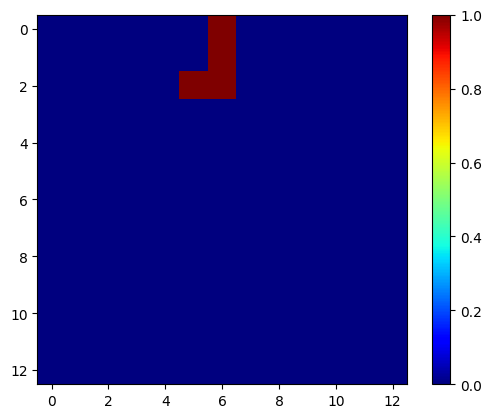

['pointy', 'tops', 'urn', 'containers']


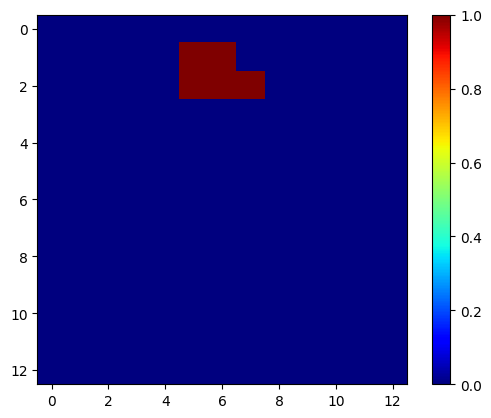

['poles', 'legs']


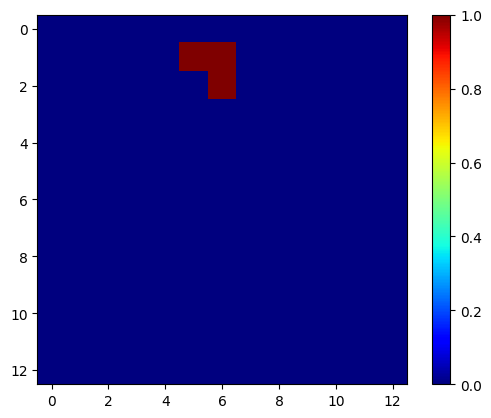

[]


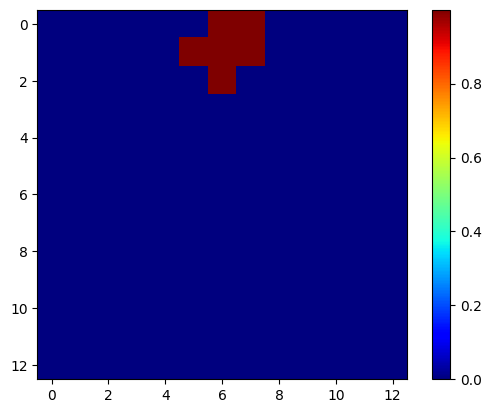

['top']


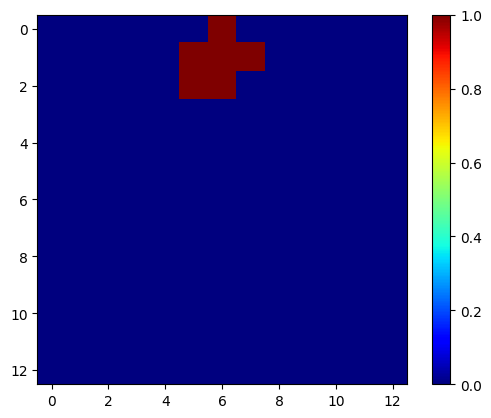

['vertical']


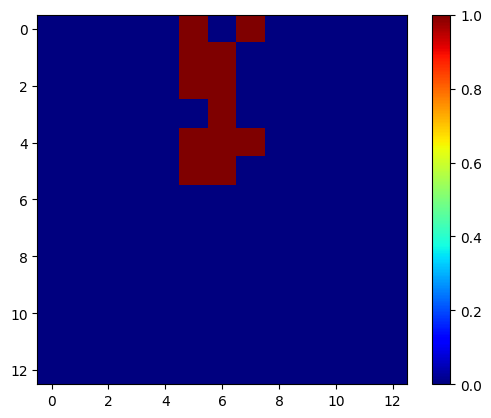

['circular']


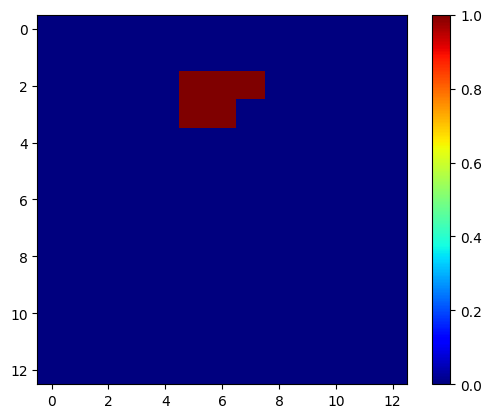

['circles']


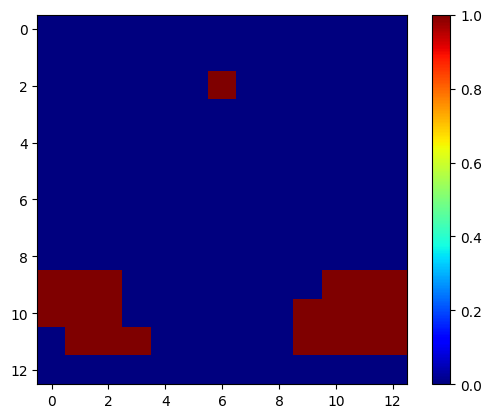

['ocean']


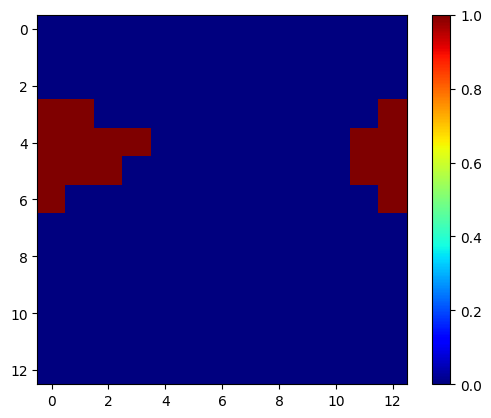

['flower', 'petals']


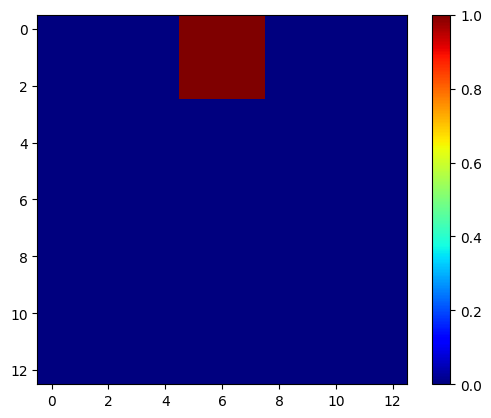

In [ ]:
from male import get_positions
per_layer_positions = get_positions(per_layer_results, per_layer_activations)

In [ ]:
explanation = list()
explanation.append("The model's decision is")
explanation.append(categories[0])
explanation.append('because it discovered')
for ln in final_results.keys():
    for unit_id in final_results[ln].keys():
        if len(final_results[ln][unit_id]) > 1:
            for word in final_results[ln][unit_id]:
                explanation.append(word)
                explanation.append('and')
            del explanation[-1]
        else:
            explanation.append(final_results[ln][unit_id][0])
        explanation.append(f'at the')
        if len(per_layer_positions[ln][unit_id]) > 1:
            for pos in per_layer_positions[ln][unit_id]:
                explanation.append(pos)
                explanation.append(',')
            del explanation[-1]
            del explanation[-2]
            explanation.insert(-1, 'and the')
        else:
            explanation.append(per_layer_positions[ln][unit_id][0])
        explanation.append('of the image')
        explanation.append(f'({ln} neuron number {unit_id})')
        if len(final_results[ln].keys()) > 1:
            explanation.append(', \n')
if ',' in explanation[-1]: 
    del explanation[-1]
explanation.append('.')
print(' '.join(explanation))
        

The model's decision is fountain because it discovered tops and buildings at the top of the image (conv5 neuron number 232) , 
 tops and containers at the top of the image (conv5 neuron number 2) , 
 top at the top of the image (conv5 neuron number 188) , 
 vertical at the top and the center of the image (conv5 neuron number 31) , 
 circular at the top of the image (conv5 neuron number 10) , 
 circles at the left , right , top and the bottom of the image (conv5 neuron number 187) , 
 ocean at the left , right and the top of the image (conv5 neuron number 57) , 
 flower at the top of the image (conv5 neuron number 204) .


In [ ]:
per_layer_results

{'conv5': {232: ['tops', 'buildings'],
  2: ['pointy', 'tops', 'urn', 'containers'],
  211: ['poles', 'legs'],
  254: [],
  188: ['top'],
  31: ['vertical'],
  10: ['circular'],
  187: ['circles'],
  57: ['ocean'],
  204: ['flower', 'petals']}}

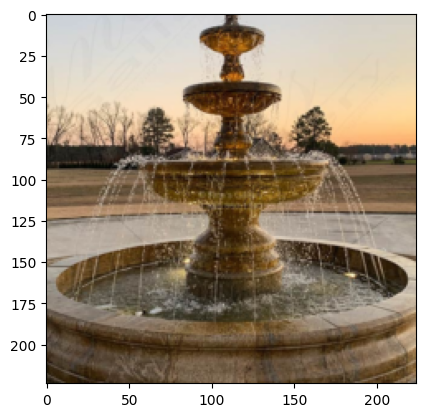

In [ ]:
plt.imshow(image_center_resized)
plt.show()

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
%autoreload 2
from male import associate_channels
x = associate_channels(input_batch=input_batch, 
                       prev_layer=layer_map['conv4'], 
                       prev_out_channels=256,
                       curr_layer=layer_map['conv5'], 
                       target_ch_id=204, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[104, 177, 250, 3, 152, 180, 96, 166, 71, 48]


In [ ]:
query = descriptions[descriptions['layer'] == 'conv4']
tops = list(torch.argsort(x).numpy())[:5]
print(tops)
query =  query[query['unit'].isin(tops)]
query.set_index('unit', inplace=True)
query = query.loc[tops]
query.reset_index(inplace=True)
query

[104, 177, 250, 3, 152]


,unit,layer,description
0,104,conv4,Black and white colored objects
1,177,conv4,Circles
2,250,conv4,Landscapes
3,3,conv4,Edges of objects
4,152,conv4,Circular objects


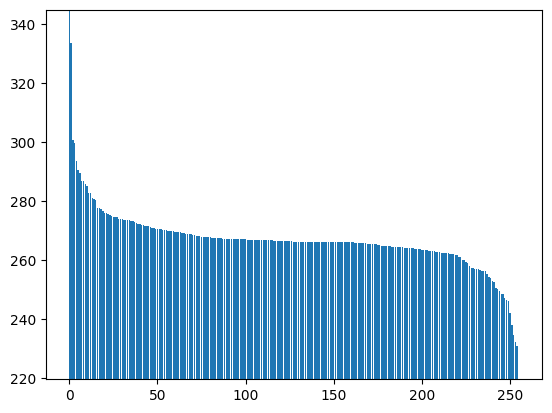

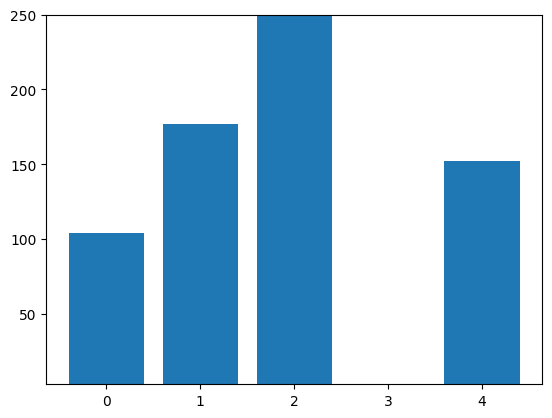

In [ ]:
import matplotlib.pyplot as plt
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)
plt.show()
plt.ylim(min(tops), max(tops))
plt.bar(range(len(tops)), tops)
plt.show()

In [ ]:
y

[tensor(26.6699),
 tensor(26.4871),
 tensor(26.4137),
 tensor(26.0953),
 tensor(25.8806),
 tensor(25.7639),
 tensor(25.4984),
 tensor(25.4532),
 tensor(25.3886),
 tensor(25.3750),
 tensor(25.3709),
 tensor(25.3666),
 tensor(25.3286),
 tensor(25.2933),
 tensor(25.2754),
 tensor(25.2615),
 tensor(25.2130),
 tensor(25.1406),
 tensor(25.1364),
 tensor(25.1239),
 tensor(25.1119),
 tensor(25.1053),
 tensor(25.0860),
 tensor(25.0857),
 tensor(25.0629),
 tensor(25.0584),
 tensor(25.0566),
 tensor(25.0254),
 tensor(25.0058),
 tensor(24.9741),
 tensor(24.9686),
 tensor(24.9616),
 tensor(24.9548),
 tensor(24.9477),
 tensor(24.8845),
 tensor(24.8721),
 tensor(24.8680),
 tensor(24.8642),
 tensor(24.8633),
 tensor(24.8567),
 tensor(24.8303),
 tensor(24.8196),
 tensor(24.8190),
 tensor(24.8087),
 tensor(24.8031),
 tensor(24.7815),
 tensor(24.7639),
 tensor(24.7543),
 tensor(24.7497),
 tensor(24.7475),
 tensor(24.7432),
 tensor(24.7340),
 tensor(24.7283),
 tensor(24.7192),
 tensor(24.7189),
 tensor(24